# Projeto 3

<b>Tema:</b> Estimar o retorno financeiro de um filme

<b>Técnica:</b> Regressão Linear

<b>Grupo:</b> Lucas Leal Vale, Matheus Augusto Soares, Rafael Almada
___

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

___
## _Introdução_

Neste projeto, o objetivo final do grupo, é conseguir estimar com certa precisão o retorno financeiro de um filme hipotético X dado algumas características do mesmo. Para isso estamos utilizando uma base de dados que pode ser encontrada no link abaixo:

Link do DataSet: https://www.kaggle.com/rounakbanik/the-movies-dataset#movies_metadata.csv

___

### _Filtrando a Base de Dados_

In [2]:
#Limpando DataFrame
movies=pd.read_csv('movies_metadata.csv', low_memory=False)
df=movies.loc[:, {'id','original_title','original_language','genres','popularity','runtime','budget','revenue',
                 'production_companies','production_countries', 'release_date','vote_average',}]

In [3]:
# Tirando valores de budget que estavam como arquivos de imagens e não números
df=df.drop([19730, 29503, 35587])

# Colocando algumas colunas como float para analisá-las quantitativamente
df['budget']=df['budget'].astype('float64')
df['popularity']=df['popularity'].astype('float64')
df['id']=df['id'].astype('float64')

In [4]:
#Ordenando em ordem crescente de acordo com o id, e filtrando valores 0 das variáveis float
df=df[(df['revenue']>0) & (df['budget']>0)  & (df['runtime']>0)]
df=df.sort_values(['id'], ascending=[True])
df['id']=df['id'].astype('int')
df=df.set_index('id')

___
## _Análise Exploratória dos Dados_

Aqui começamos a análise exploratória dos dados. Nosso objetivo nessa etapa é analisar como a nossa base de dados se comporta, para que assim, ao decorrer do código, é importante que estejamos cientes de como cada variável se organiza.

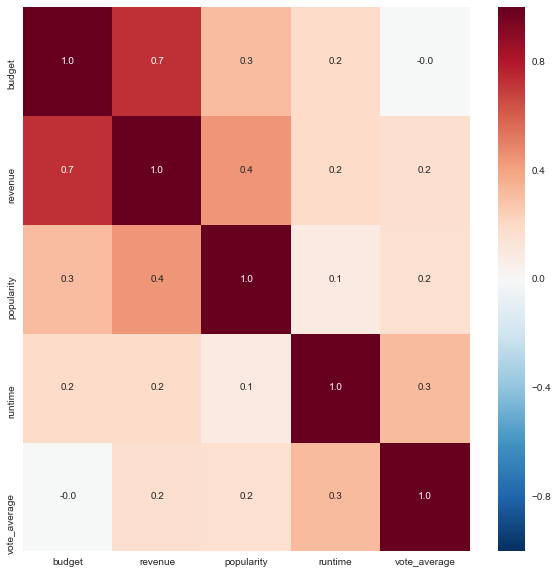

In [5]:
f,ax = plt.subplots(figsize = (10,10))
sns.heatmap(df.corr(),annot = True,fmt='.1f')

Com o gráfico acima obtemos os resultados das correlações entre cada coluna (variável). Como queremos achar uma forma de estimar o retorno financeiro de um filme ao final do projeto, precisamos analisar as variáveis em relação à variável 'Revenue'. Dessa forma percebemos que, em nossa regressão, quanto maior a correlação de uma variável X em relação à nossa variável fixada (revenue), quanto mais próxima a 1, seja positiva ou negativamente, mais importante será na nossa regressão tal variável.

Logo, das variáveis escolhidas até o momento, podemos dizer que em ordem de maior relevância no cálculo da nossa regressão estão em ordem decrescente, primeiro Budget (ou custo de produção do filme), o qual era esperado ter grande impacto no retorno do mesmo. Logo em seguida vem Popularity ou a popularidade do filme (quanto falam dele). Depois, juntos, seguem as variáveis Runtime (Tempo corrido em tela do filme) e Vote Average (Nota do filme dada pela comunidade).

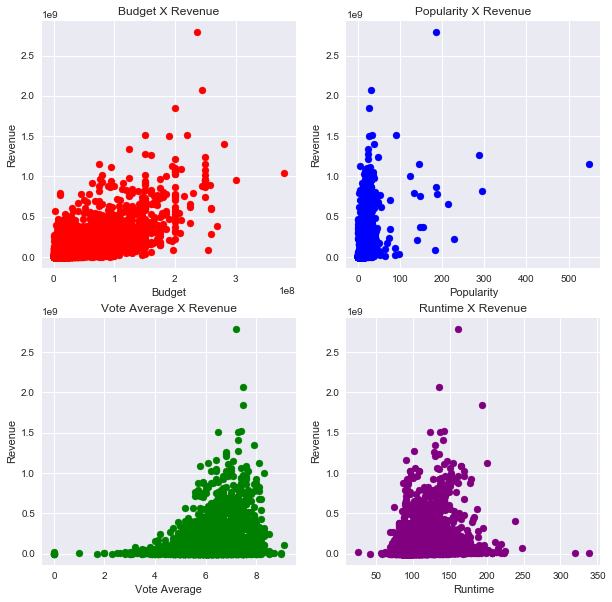

In [6]:
# Alguns ScatterPlot para analisar a dispersão dos dados em relação a revenue
fig=plt.figure(figsize=(10, 10))

# Budget X Revenue
plt.subplot(221)
plt.scatter(df.budget,df.revenue, color='red')
plt.title('Budget X Revenue')
plt.ylabel('Revenue')
plt.xlabel('Budget')

# Popularity X Revenue
plt.subplot(222)
plt.scatter(df.popularity,df.revenue, color='blue')
plt.title('Popularity X Revenue')
plt.ylabel('Revenue')
plt.xlabel('Popularity')

# Vote Average X Revenue
plt.subplot(223)
plt.scatter(df.vote_average,df.revenue, color='green')
plt.title('Vote Average X Revenue')
plt.ylabel('Revenue')
plt.xlabel('Vote Average')

#Runtime X Revenue
plt.subplot(224)
plt.scatter(df.runtime,df.revenue, color='purple')
plt.title('Runtime X Revenue')
plt.ylabel('Revenue')
plt.xlabel('Runtime')

plt.show()

Nos gráficos de dispersão acima podemos verificar o quão dispersos são os dados e visualiza-los em relação ao retorno financeiro (revenue). Percebemos que, como já visto em suas respectivas correlações, todos são positivos, logo quando o retorno é maior, a váriavel em questão (seja budget, popularidade ou tempo corrido) também é maior. A diferença desse gráfico para a tabela de correlações é que como já diz o nome deste, podemos verificar a disperção das variáveis.

A parte curiosa disso é que alguns filmes conseguem um retorno alto, mesmo tendo uma produção barata seja por motivos quaisquer, como é o caso de alguns filmes de terror que por não usar muito dinheiro, sua credibilidade aumenta, aumentando no caso também o fator "Terror" e assim chegando a cada vez mais cinemas e conseguindo um retorno de um filme blockbuster produzido por alguma empresa grande. Além disso, os gráficos nos mostram que um filme popular entre as pessoas, não necessariamente vai trazer um retorno alto.

Também temos dois gráficos que parecem um pouco com uma distribuição normal, possuindo uma média de tempo corrido de tela e classificação (ou nota) do público para o filme para um retorno maior do longa.

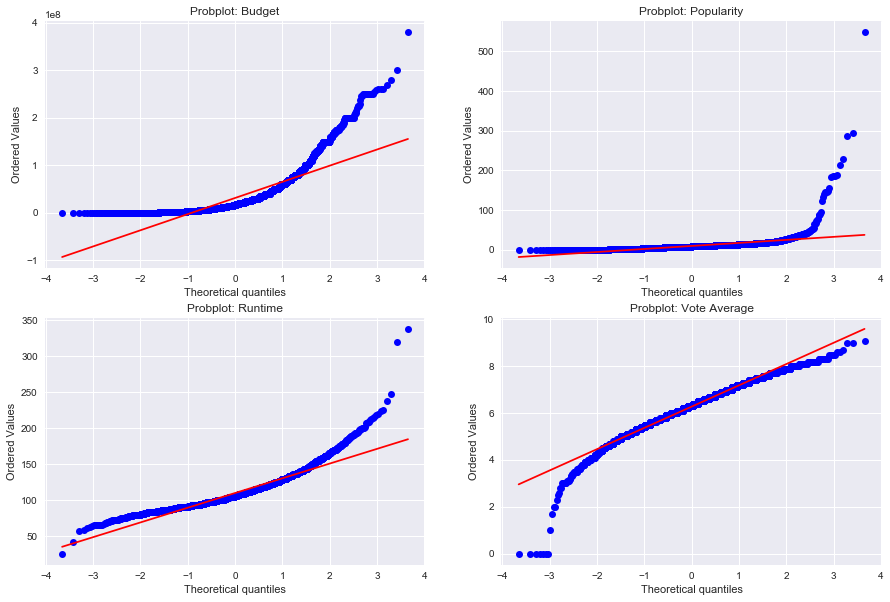

In [7]:
# Gráficos que verificam se alguma das variáveis analisadas tende a uma distribuição normal
fig=plt.figure(figsize=(15, 10))

plt.subplot(221)
stats.probplot(df.budget, plot=plt)
plt.title('Probplot: Budget')

plt.subplot(222)
stats.probplot(df.popularity, plot=plt)
plt.title('Probplot: Popularity')

plt.subplot(223)
stats.probplot(df.runtime, plot=plt)
plt.title('Probplot: Runtime')

plt.subplot(224)
stats.probplot(df.vote_average, plot=plt)
plt.title('Probplot: Vote Average')
plt.show()

Os Probability Plots acima (gráficos que medem o quanto uma base e dados se distribui conforme uma distribuição Gaussiana ou Normal), nos mostram que nenhum das variáveis se comporta como uma. A hipótese que tínhamos anteriormente nos gráficos de dispersão, de que as variáveis "Runtime" (tempo corrido de tela) e "Vote Average" (nota do filme pelo público) seguem tal distribuição não se confirmam. Pelo incrível que pareça, a variável que mais tende a tal é a de popularidade do filme com o público, independendo de sua nota dada pelo mesmo. Porém não se pode dizer que nenhuma das variáveis se distribui de forma gaussiana, anulando essas hipóteses.

Agora podemos seguir adiante da Análise exploratória dos dados.

___
## Iniciando a Regressão Linear Múltipla

In [8]:
X=df[['budget', 'popularity', 'runtime', 'vote_average']]
xc=sm.add_constant(X)
model=sm.OLS(df.revenue,xc)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     2035.
Date:                Thu, 22 Nov 2018   Prob (F-statistic):               0.00
Time:                        11:14:53   Log-Likelihood:            -1.0677e+05
No. Observations:                5369   AIC:                         2.135e+05
Df Residuals:                    5364   BIC:                         2.136e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.761e+08   1.08e+07    -16.266      0.000   -1.97e+08   -1.55e+08
budget           2.7534      0.038     71.942      0.000       2.678       2.828
popularity    2.566e+06    1.1e+05     23.235      0.000    2.35e+06    2.78e+06
runtime       2225.7085   7.17e+04      0.031      0.975   -1.38e+05    1.43e+05
vote_average  2.478e+07   1.66e+06     14.915      0.000    2.15e+07     2.8e+07
==============================================================================
Omnibus:                     4175.948   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           229343.981
Skew:                           3.245   Prob(JB):                         0.00
Kurtosis:                      34.354   Cond. No.                     3.87e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.87e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Com o primeiro teste de regressão linear múltipla feita na célula acima (utilizando a biblioteca Statsmodels), conseguimos ter uma visão inicial do caminho que devemos seguir a partir de agora. Vamos analisar!

Primeiro vamos olhar para o nosso **`R`²** que possui o valor de **0.603**. Dado esse valor, sabemos que a regressão ainda tem muito a ser melhorada (quanto mais próximo de **1** o **`R²`**, mais preciso está o modelo), devemos olhar para mais variáveis que possam explicar nosso modelo. No caso utilizamos por enquanto apenas as variáveis quantitativas, mas ainda temos algumas Qualitativas para implementar em nosso modelo.

A segunda coisa que devemos dar nossa atenção são as **`P-values`**, sendo que todas as variáveis, exceto uma, possuem um **`p-value`** de **0**, porém temos _runtime_ que possui **0.975**. O problema de um valor alto nesse caso é porque isso prova que a variável em questão está mais atrapalhando do que ajudando a precisão da nossa regressão.

As últimas coisas que devemos dar enfoque na primeira análise do modelo são a **`Prob(F-statistic)`**, a **`Prob(Omnibus)`** e a **`Prob(Jarque-Bera)`**. No caso a **`F-statistic`** coloca sob a hipótese nula de que todos os $\beta$ 's (a não ser o $\beta_0$) são iguais a zero e verifica o quão próximo tal modelo estaria do então calculado. Dado que a probabildade é **0**, logo podemos afirmar que o modelo precisa de tais variáveis.

Já a **`Prob(Omnibus)`** testa se os resíduos do nosso modelo tendem a uma normal. É importante que os resíduos tendam a uma distribuição gaussiana, pois se os resíduos não se distribuírem como uma normal, então a hipótese de que eles se comportam como uma amostra aleatória de uma população maior será dada como uma mentira e isso comprometerá totalmente a veracidade da regressão. No caso temos **$Prob(Omnibus) = 0.00$**, sendo assim não podemos confiar neste modelo. 

Ainda temos a **`Prob(JB)`** que realiza o teste chamado **`Jarque-Bera`**, que utiliza as mesmas hipóteses que o teste **`Omnibus`**, porém utilizando um método diferente, fazendo uso do grau de assimetria da distribuição (Skew) e do grau de achatamento da mesma (Kurtosis). Um **`Skew`** mais próximo de **0** e um **`Kurtosis`** mais próximo de **3** são os mais precisos para uma distribuição gaussiana dos resíduos, porém ainda temos resíduos _"reprovados"_ em ambos os testes.

In [9]:
# Removendo a coluna df.runtime
df=df.loc[:,['release_date','popularity','original_title','vote_average','original_language','revenue','production_countries',
            'genres','production_companies','budget']]

In [10]:
# As colunas de empresas e países que produziram estavam em um dicionário que estava dentro de uma string, então montamos a 
# função abaixo que transformam o conteudo de cada filme em uma lista a ser manipulada
def transforma(df,parametro):
    def dicio(df): #Ex: df = df.production_countries ; parametro = 'iso_3166_1'
        count=0
        dicio=''
        for i in df:
            if i=="{":
                count=1
            if count==1:
                dicio+=i
            if i=="}":
                dicio+=';'
                count=2
            if i=="]":
                break
        dicio=dicio.split(';')
        del(dicio[-1]) #removendo string vazia
        return dicio
# Agora precisamos percorrer todos os filmes com a função dicio    
    dicio2=[]
    for i in df.index:
        dicio2.append(dicio(df[i]))
# Agora, para cada filme na lista dicio2, iremos transformar cada empresa/país de string para dicionário
    for x in range(len(dicio2)):
        a=[]
        #country=[]
        for filme in dicio2[x]:
            a.append(eval(filme))
        dicio2[x]=a
# Iremos manipular os dicionários e extrair somente as siglas dos países/empresas
    country=[]
    for filme in dicio2:
        film=[]
        for pais in filme:
            sigla=pais[parametro]
            film.append(sigla)
        country.append(film)
    return country

Agora que a regressão já foi gerada é necessário tentar melhorá-la com as colunas qualitativas do dataframe. E para poder fazer uso delas é necessário trata-las, primeiro transformando em strings simples e depois adicionando no dataframe base 'df'.

In [11]:
# Aplicando a nossa função e adicionando o nome dos países de produção em uma coluna mais fácil de ser utilizada na regressão

In [12]:
# # Arrumando a coluna de pais de produção para ser utilizada na regressão
# country=transforma(df.production_countries,'iso_3166_1')
# country=pd.Series(country)
# df['country']=country

In [13]:
# # Precisamos retirar '[]' das células de df.country
# df['country']=df.country.astype(str).str.replace('\[|\]|\'', '')

In [14]:
# # transformando a coluna country em um dataframe quantitativo 
# country=pd.get_dummies(df.country)

In [15]:
# df=df.merge(country, how='inner', on='id')

In [16]:
# # Arrumando a coluna de linguas para ser utilizada na regressão
# language=pd.get_dummies(df.original_language)

In [17]:
# # adicionando novo dataframe ao antigo com a lingua original de cada pais
# language=language.add_suffix('_')
# df=df.merge(language, how='inner', on='id')

In [18]:
# # Arrumando a coluna de companias para ser utilizada na regressão
# companies=transforma(df.production_companies,'name')
# companies=pd.Series(companies)
# df['company']=companies
# df['company']=df.company.astype(str).str.replace('\[|\]|\'', '')

In [19]:
# # transformando a coluna company em um dataframe quantitativo 
# compania=pd.get_dummies(df.company)

In [20]:
# # adicionando novo dataframe ao antigo com a compania de cada filme 
# df=df.merge(compania, how='inner', on='id')

In [21]:
# Arrumando a coluna de genêros para ser utilizada na regressão
genero=transforma(df.genres,'name')
genero=pd.Series(genero)
df['genero']=genero
#df['genero']=df.genero.astype(str).str.replace('\[|\]|\'', '')
genero

0                                         [Crime, Comedy]
1                    [Adventure, Action, Science Fiction]
2                                     [Animation, Family]
3                                [Comedy, Drama, Romance]
4                                                 [Drama]
5                                        [Mystery, Drama]
6                                   [Drama, Crime, Music]
7       [Adventure, Fantasy, Action, Thriller, Science...
8                                [Drama, Science Fiction]
9                            [Adventure, Fantasy, Action]
10                                        [Action, Crime]
11                                           [Drama, War]
12                                [Drama, Music, Romance]
13                                           [Drama, War]
14                                              [Western]
15                            [Animation, Comedy, Family]
16                      [Science Fiction, Drama, Romance]
17            

In [22]:
# # transformando a coluna genêro em um dataframe quantitativo 
# generos=pd.get_dummies(df.genero)

In [23]:
# # adicionando novo dataframe ao principal ('df') com os genêros de cada filme 
# df=df.merge(generos, how='inner', on='id')

In [24]:
# # Criando um novo dataframe para ver se a o pais de origem ira melhorar nossa regressao, devido ao significativo aumento de colunas
# # sera mais facil tirar aquelas que nao queremos ao inves de falar as que queremos dentro da regressao
# #'genero'
# dfg=df
# dfg=dfg.drop(columns=['revenue','release_date','original_title','original_language','production_countries','genres','production_companies','country','company','genero'])

In [25]:
# # Rodando a regressão com as variaveis qualitativas recém transformadas em quantitativas para ver se a regressão melhorou.
# X=dfg
# xc=sm.add_constant(X)
# model=sm.OLS(df.revenue,xc)
# results=model.fit()
# results.summary()

Na célula de código acima, após diversas filtragens nos dados e se utilizando de funções já prontas das bibliotecas, conseguimos uma regressão mais precisa que antes. Agora com váriaveis Quantitativas (numéricas) e Qualitativas ou Categóricas. Lembrando que a primeira coisa a ser observada em um modelo de Regressão é o **$R^2$**, que com apenas as variáveis numéricas, possuía o valor de **`0.603`**, o que significa que budget (orçamento do filme), tempo corrido de tela, nota do filme dada pelo público e popularidade entre o público em geral explicam **60.3%** do retorno financeiro de um filme qualquer. Ao adicionar mais algumas variáveis Categóricas que achamos que poderiam ajudar nossa regressão, este valor subiu para **`0.712`** **(ATUALIZAR ESSE VALOR COM GÊNERO)**., um aumento de quase **`10.9%`** **(ATUALIZAR)** ao nosso **$R^2$**. Foi adicionado à regressão as seguintes variáveis: `Línguagem original do filme`, `Empresas que produziram o filme`, `Países envolvidos na produção` e `gêneros dos filmes`.

Por conta de como o pandas cria um dataframe transformando uma variável categórica em várias quantitativas (função `get_dummies`), acabamos com muitas variáveis que por serem tantas, cada uma explica uma porcentagem pequena do modelo, tendo um **`p-value`** consideravelmente alto para cada uma separada, mas sabemos que quando avaliadas como uma variável categórica, não afetam o modelo de fato, sendo o **`Prob(F-statistic)`** igual a **0** e portanto o modelo realmente precisa das variáveis utilizadas.

Continuamos também com uma **`Prob(Omnibus)`** e **`Prob(JB)`** de **0**, colocando em prova de que os resíduos estão se distribuindo como uma normal.

O modelo está preciso e consegue explicar **71.2%** do retorno financeiro de um filme qualquer.

___
## Conclusão

Concluindo, devemos relembrar a pergunta feita no início do projeto: Quais variáveis são necessárias para se explicar o retorno financeiro de um filme?

Ao longo do projeto, percebemos que variáveis quantitativas têm uma significância maior e, portanto, são mais significantes no modelo de regressão do rendimento financeiro de um filme qualquer. O mais impactante para o modelo seria o budget (valor total para se produzir o filme).
**[PRECISO TERMINAR AINDA]**

In [26]:
genero

0                                         [Crime, Comedy]
1                    [Adventure, Action, Science Fiction]
2                                     [Animation, Family]
3                                [Comedy, Drama, Romance]
4                                                 [Drama]
5                                        [Mystery, Drama]
6                                   [Drama, Crime, Music]
7       [Adventure, Fantasy, Action, Thriller, Science...
8                                [Drama, Science Fiction]
9                            [Adventure, Fantasy, Action]
10                                        [Action, Crime]
11                                           [Drama, War]
12                                [Drama, Music, Romance]
13                                           [Drama, War]
14                                              [Western]
15                            [Animation, Comedy, Family]
16                      [Science Fiction, Drama, Romance]
17            

In [27]:
def coluna(df):
    lista=[]
    for i in df:
        for j in i:
            if j not in lista:
                lista.append(j)
            else:
                pass
    return lista

In [28]:
coluna(genero)

['Crime',
 'Comedy',
 'Adventure',
 'Action',
 'Science Fiction',
 'Animation',
 'Family',
 'Drama',
 'Romance',
 'Mystery',
 'Music',
 'Fantasy',
 'Thriller',
 'War',
 'Western',
 'History',
 'Horror',
 'Documentary',
 'Foreign',
 'TV Movie']

In [29]:
df2 = df.copy()

In [30]:
df2

,release_date,popularity,original_title,vote_average,original_language,revenue,production_countries,genres,production_companies,budget,genero
id,,,,,,,,,,,
5,1995-12-09,9.026586,Four Rooms,6.5,en,4.300000e+06,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...","[{'name': 'Miramax Films', 'id': 14}, {'name':...",4000000.0,"[Mystery, Drama]"
11,1977-05-25,42.149697,Star Wars,8.1,en,7.753980e+08,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...","[{'name': 'Lucasfilm', 'id': 1}, {'name': 'Twe...",11000000.0,"[Drama, War]"
12,2003-05-30,25.497794,Finding Nemo,7.6,en,9.403355e+08,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 16, 'name': 'Animation'}, {'id': 10751...","[{'name': 'Pixar Animation Studios', 'id': 3}]",94000000.0,"[Drama, Music, Romance]"
13,1994-07-06,48.307194,Forrest Gump,8.2,en,6.779454e+08,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'name': 'Paramount Pictures', 'id': 4}]",55000000.0,"[Drama, War]"
14,1999-09-15,20.726578,American Beauty,7.9,en,3.562966e+08,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 18, 'name': 'Drama'}]","[{'name': 'DreamWorks SKG', 'id': 27}, {'name'...",15000000.0,[Western]
15,1941-04-30,15.811921,Citizen Kane,8.0,en,2.321767e+07,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 9648, 'name': 'Mystery'}, {'id': 18, '...","[{'name': 'RKO Radio Pictures', 'id': 6}, {'na...",839727.0,"[Animation, Comedy, Family]"
16,2000-05-17,10.684806,Dancer in the Dark,7.7,en,4.003188e+07,"[{'iso_3166_1': 'AR', 'name': 'Argentina'}, {'...","[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...","[{'name': 'Fine Line Features', 'id': 8}, {'na...",12800000.0,"[Science Fiction, Drama, Romance]"
18,1997-05-07,24.305260,The Fifth Element,7.3,en,2.639202e+08,"[{'iso_3166_1': 'FR', 'name': 'France'}]","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",90000000.0,"[Adventure, Fantasy, Action]"
19,1927-01-10,14.487867,Metropolis,8.0,de,6.504220e+05,"[{'iso_3166_1': 'DE', 'name': 'Germany'}]","[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...","[{'name': 'Paramount Pictures', 'id': 4}, {'na...",92620000.0,"[Drama, Thriller, Crime]"


In [31]:
tipofilme=coluna(genero)
tipofilme

['Crime',
 'Comedy',
 'Adventure',
 'Action',
 'Science Fiction',
 'Animation',
 'Family',
 'Drama',
 'Romance',
 'Mystery',
 'Music',
 'Fantasy',
 'Thriller',
 'War',
 'Western',
 'History',
 'Horror',
 'Documentary',
 'Foreign',
 'TV Movie']

In [32]:
for nome in coluna(genero):
    df2[nome] = 0

In [33]:
df2.head(3)

,release_date,popularity,original_title,vote_average,original_language,revenue,production_countries,genres,production_companies,budget,...,Music,Fantasy,Thriller,War,Western,History,Horror,Documentary,Foreign,TV Movie
id,,,,,,,,,,,,,,,,,,,,,
5,1995-12-09,9.026586,Four Rooms,6.5,en,4300000.0,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...","[{'name': 'Miramax Films', 'id': 14}, {'name':...",4000000.0,...,0,0,0,0,0,0,0,0,0,0
11,1977-05-25,42.149697,Star Wars,8.1,en,775398007.0,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...","[{'name': 'Lucasfilm', 'id': 1}, {'name': 'Twe...",11000000.0,...,0,0,0,0,0,0,0,0,0,0
12,2003-05-30,25.497794,Finding Nemo,7.6,en,940335536.0,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 16, 'name': 'Animation'}, {'id': 10751...","[{'name': 'Pixar Animation Studios', 'id': 3}]",94000000.0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
df2.genero

id
5                               [Mystery, Drama]
11                                  [Drama, War]
12                       [Drama, Music, Romance]
13                                  [Drama, War]
14                                     [Western]
15                   [Animation, Comedy, Family]
16             [Science Fiction, Drama, Romance]
18                  [Adventure, Fantasy, Action]
19                      [Drama, Thriller, Crime]
22                              [Drama, Romance]
24                      [Crime, Drama, Thriller]
25                       [Drama, Music, Romance]
27                        [Drama, Comedy, Music]
28                                       [Drama]
33            [Science Fiction, Drama, Thriller]
35                              [Drama, Romance]
38                             [Drama, Thriller]
55                             [Thriller, Crime]
58                               [Comedy, Crime]
59             [Drama, Thriller, Crime, Romance]
62               

In [35]:
k  = 5
m = "Western"
df2.loc[k,:].genero


['Mystery', 'Drama']

In [36]:
for k in df2.index:
    print(k)
    gens = df2.loc[k,:].genero
    print(type(gens))
    for g in gens:
        print(g)


5
<class 'list'>
Mystery
Drama
11
<class 'list'>
Drama
War
12
<class 'list'>
Drama
Music
Romance
13
<class 'list'>
Drama
War
14
<class 'list'>
Western
15
<class 'list'>
Animation
Comedy
Family
16
<class 'list'>
Science Fiction
Drama
Romance
18
<class 'list'>
Adventure
Fantasy
Action
19
<class 'list'>
Drama
Thriller
Crime
22
<class 'list'>
Drama
Romance
24
<class 'list'>
Crime
Drama
Thriller
25
<class 'list'>
Drama
Music
Romance
27
<class 'list'>
Drama
Comedy
Music
28
<class 'list'>
Drama
33
<class 'list'>
Science Fiction
Drama
Thriller
35
<class 'list'>
Drama
Romance
38
<class 'list'>
Drama
Thriller
55
<class 'list'>
Thriller
Crime
58
<class 'list'>
Comedy
Crime
59
<class 'list'>
Drama
Thriller
Crime
Romance
62
<class 'list'>
Adventure
Fantasy
Action
63
<class 'list'>
Adventure
Fantasy
Action
64
<class 'list'>
Adventure
Fantasy
Action
65
<class 'list'>
Fantasy
Drama
Animation
Adventure
66
<class 'list'>
Adventure
Fantasy
Animation
69
<class 'list'>
Romance
Fantasy
Drama
Comedy
70
<clas

TypeError: 'float' object is not iterable

In [37]:
k = 5
m = "Mystery"
df2.loc[k,:].genero

['Mystery', 'Drama']

In [38]:
# #df2nn = df2.dropna(subset=df2.genero )


for k in df2.index:
    gens = df2.loc[k,:].genero
   
    for g in gens:
        df2.loc[k,g]=1

TypeError: 'float' object is not iterable

In [39]:
# tipofilme- todos o generos sem repeticao, nao pertence ao dataframe, e apenas uma lista
# df2.genero - cada filme dentro do index id e sua combinacao de generos, pertence ao dataframe principal

#for tema in tipofilme:
# for i in df2.index:
#     for gen in df2.genero:
#         for j in gen:
#             for tema in tipofilme:
#                 if j==tema:
#                     df2[j][i]=1
#                 else:
#                     pass
#             #df2[j][i]=1
#         #print(gen)
#         #print(i)
#         #df2[gen][i]=1

In [40]:
df2

,release_date,popularity,original_title,vote_average,original_language,revenue,production_countries,genres,production_companies,budget,...,Music,Fantasy,Thriller,War,Western,History,Horror,Documentary,Foreign,TV Movie
id,,,,,,,,,,,,,,,,,,,,,
5,1995-12-09,9.026586,Four Rooms,6.5,en,4.300000e+06,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...","[{'name': 'Miramax Films', 'id': 14}, {'name':...",4000000.0,...,0,0,0,0,0,0,0,0,0,0
11,1977-05-25,42.149697,Star Wars,8.1,en,7.753980e+08,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...","[{'name': 'Lucasfilm', 'id': 1}, {'name': 'Twe...",11000000.0,...,0,0,0,1,0,0,0,0,0,0
12,2003-05-30,25.497794,Finding Nemo,7.6,en,9.403355e+08,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 16, 'name': 'Animation'}, {'id': 10751...","[{'name': 'Pixar Animation Studios', 'id': 3}]",94000000.0,...,1,0,0,0,0,0,0,0,0,0
13,1994-07-06,48.307194,Forrest Gump,8.2,en,6.779454e+08,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'name': 'Paramount Pictures', 'id': 4}]",55000000.0,...,0,0,0,1,0,0,0,0,0,0
14,1999-09-15,20.726578,American Beauty,7.9,en,3.562966e+08,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 18, 'name': 'Drama'}]","[{'name': 'DreamWorks SKG', 'id': 27}, {'name'...",15000000.0,...,0,0,0,0,1,0,0,0,0,0
15,1941-04-30,15.811921,Citizen Kane,8.0,en,2.321767e+07,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 9648, 'name': 'Mystery'}, {'id': 18, '...","[{'name': 'RKO Radio Pictures', 'id': 6}, {'na...",839727.0,...,0,0,0,0,0,0,0,0,0,0
16,2000-05-17,10.684806,Dancer in the Dark,7.7,en,4.003188e+07,"[{'iso_3166_1': 'AR', 'name': 'Argentina'}, {'...","[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...","[{'name': 'Fine Line Features', 'id': 8}, {'na...",12800000.0,...,0,0,0,0,0,0,0,0,0,0
18,1997-05-07,24.305260,The Fifth Element,7.3,en,2.639202e+08,"[{'iso_3166_1': 'FR', 'name': 'France'}]","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",90000000.0,...,0,1,0,0,0,0,0,0,0,0
19,1927-01-10,14.487867,Metropolis,8.0,de,6.504220e+05,"[{'iso_3166_1': 'DE', 'name': 'Germany'}]","[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...","[{'name': 'Paramount Pictures', 'id': 4}, {'na...",92620000.0,...,0,0,1,0,0,0,0,0,0,0


In [41]:
lista=[]
print('oi')
film=[]
if len(lista)==0:
    film.append([0])
else:
    for i in lista:
        film.append(lista)
print(film)

oi
[[0]]


In [42]:
len(lista)

0

In [43]:
genero

0                                         [Crime, Comedy]
1                    [Adventure, Action, Science Fiction]
2                                     [Animation, Family]
3                                [Comedy, Drama, Romance]
4                                                 [Drama]
5                                        [Mystery, Drama]
6                                   [Drama, Crime, Music]
7       [Adventure, Fantasy, Action, Thriller, Science...
8                                [Drama, Science Fiction]
9                            [Adventure, Fantasy, Action]
10                                        [Action, Crime]
11                                           [Drama, War]
12                                [Drama, Music, Romance]
13                                           [Drama, War]
14                                              [Western]
15                            [Animation, Comedy, Family]
16                      [Science Fiction, Drama, Romance]
17            

In [63]:
filmeex = "[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]"

In [64]:
def genero(filme):
    l=eval(filme)
    retl = []
    c=0
    for i in l:
        genero=i['name']
        c+=1
        retl.append(genero)
    return retl


In [65]:
genero(filmeex)

['Romance', 'Comedy']

In [69]:
df2['GENERO']=df2.genres.apply(genero)
df2

,release_date,popularity,original_title,vote_average,original_language,revenue,production_countries,genres,production_companies,budget,...,Fantasy,Thriller,War,Western,History,Horror,Documentary,Foreign,TV Movie,GENERO
id,,,,,,,,,,,,,,,,,,,,,
5,1995-12-09,9.026586,Four Rooms,6.5,en,4.300000e+06,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...","[{'name': 'Miramax Films', 'id': 14}, {'name':...",4000000.0,...,0,0,0,0,0,0,0,0,0,"[Crime, Comedy]"
11,1977-05-25,42.149697,Star Wars,8.1,en,7.753980e+08,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...","[{'name': 'Lucasfilm', 'id': 1}, {'name': 'Twe...",11000000.0,...,0,0,1,0,0,0,0,0,0,"[Adventure, Action, Science Fiction]"
12,2003-05-30,25.497794,Finding Nemo,7.6,en,9.403355e+08,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 16, 'name': 'Animation'}, {'id': 10751...","[{'name': 'Pixar Animation Studios', 'id': 3}]",94000000.0,...,0,0,0,0,0,0,0,0,0,"[Animation, Family]"
13,1994-07-06,48.307194,Forrest Gump,8.2,en,6.779454e+08,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'name': 'Paramount Pictures', 'id': 4}]",55000000.0,...,0,0,1,0,0,0,0,0,0,"[Comedy, Drama, Romance]"
14,1999-09-15,20.726578,American Beauty,7.9,en,3.562966e+08,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 18, 'name': 'Drama'}]","[{'name': 'DreamWorks SKG', 'id': 27}, {'name'...",15000000.0,...,0,0,0,1,0,0,0,0,0,[Drama]
15,1941-04-30,15.811921,Citizen Kane,8.0,en,2.321767e+07,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 9648, 'name': 'Mystery'}, {'id': 18, '...","[{'name': 'RKO Radio Pictures', 'id': 6}, {'na...",839727.0,...,0,0,0,0,0,0,0,0,0,"[Mystery, Drama]"
16,2000-05-17,10.684806,Dancer in the Dark,7.7,en,4.003188e+07,"[{'iso_3166_1': 'AR', 'name': 'Argentina'}, {'...","[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...","[{'name': 'Fine Line Features', 'id': 8}, {'na...",12800000.0,...,0,0,0,0,0,0,0,0,0,"[Drama, Crime, Music]"
18,1997-05-07,24.305260,The Fifth Element,7.3,en,2.639202e+08,"[{'iso_3166_1': 'FR', 'name': 'France'}]","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",90000000.0,...,1,0,0,0,0,0,0,0,0,"[Adventure, Fantasy, Action, Thriller, Science..."
19,1927-01-10,14.487867,Metropolis,8.0,de,6.504220e+05,"[{'iso_3166_1': 'DE', 'name': 'Germany'}]","[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...","[{'name': 'Paramount Pictures', 'id': 4}, {'na...",92620000.0,...,0,1,0,0,0,0,0,0,0,"[Drama, Science Fiction]"


In [67]:
df2["listag"]  = genero(df2.genres.str)

TypeError: eval() arg 1 must be a string, bytes or code object

In [45]:
for i in df2.GENERO:
    if i==np.nan:
        print(i)

In [59]:
eval(df2.genres[5])[0]['name']

'Crime'

In [47]:
df2.GENERO[393841]

nan

In [48]:
df2.genres[393841]

"[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]"

In [49]:
df2.GENERO.astype('O')

id
5                               [Mystery, Drama]
11                                  [Drama, War]
12                       [Drama, Music, Romance]
13                                  [Drama, War]
14                                     [Western]
15                   [Animation, Comedy, Family]
16             [Science Fiction, Drama, Romance]
18                  [Adventure, Fantasy, Action]
19                      [Drama, Thriller, Crime]
22                              [Drama, Romance]
24                      [Crime, Drama, Thriller]
25                       [Drama, Music, Romance]
27                        [Drama, Comedy, Music]
28                                       [Drama]
33            [Science Fiction, Drama, Thriller]
35                              [Drama, Romance]
38                             [Drama, Thriller]
55                             [Thriller, Crime]
58                               [Comedy, Crime]
59             [Drama, Thriller, Crime, Romance]
62               

'Crime'